Adding stored data to store the trades for calculation of results

In [1]:
# Changes from 8:
# Almost similar to notebook 8, but for multiple instruments
# The adding of dictionaries, so that the data for all stocks can be stored
# Added one more func to stop trading when total capital  < 0. Previous model doesnt takes that into account.

In [2]:
# # Install all important libraries
# !pip install yfinance
# !pip install ta

# Set up

In [3]:
# # NSE list Dont run
# list = ["BRITANNIA.NS", "ULTRACEMCO.NS","KOTAKBANK.NS", "HEROMOTOCO.NS" , "BAJAJ-AUTO.NS", "GRASIM.NS","ONGC.NS", "TITAN.NS" , "SHREECEM.NS" ,\
#         "NESTLEIND.NS", "GAIL.NS", "CIPLA.NS", "BHARTIARTL.NS" ,"NTPC.NS", "TATASTEEL.NS", "COALINDIA.NS", "BAJFINANCE.NS", "ICICIBANK.NS",\
#        "BAJAJFINSV.NS", "WIPRO.NS", "HINDALCO.NS" , "HDFCLIFE.NS", "MARUTI.NS", "RELIANCE.NS", "TCS.NS", "LT.NS", "INDUSINDBK.NS", "ITC.NS" , "TECHM.NS"]

In [4]:
# # SGX list Dont run
# list = ["C52.SI", "T39.SI", "S68.SI", "G13.SI", "V03.SI" , "U11.SI", "C07.SI" , "D05.SI", "Z74.SI",\
#         "D01.SI", "O39.SI", "S63.SI", "A17U.SI" , "BN4.SI","BS6.SI", "M44U.SI", "C31.SI", "H78.SI", \
#         "Y92.SI", "C38U.SI", "U14.SI", "N2IU.SI" , "F34.SI" , "C09.SI" , "J36.SI", "S58.SI" , "C6L.SI", "J37.SI", "U96.SI" ,"1810.HK"]

In [5]:
# import all libraries

from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice

import math
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import random
from itertools import product

/Users/fiona/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [6]:
# For event based backtesting, an imporatant concept is a bar.
# A bar is unit of data or information. A bar represents an event.
# Event based Backtesting will be based on new bars coming at not on full dataset.

# First we will build a commonclass,
# this will be utilised for all the common purposes like preparing data, plotting results, placing orders etc

# Backtesting classes

### Common Class

In [7]:
class Common_Class():

  def __init__(self, trading_stocks, hodl_stocks, start, end, interval, capital, transcation_cost, verbose = True):

    #new dicts
    symbol = trading_stocks + hodl_stocks
    self.all_data ={}
    self.position = {} # position also a dict, commonenting out the self.position = 0
    self.quantity = {} # quantity also a dict. initialising with zero quantitties to all the shares
    for stock in symbol:
      self.quantity['{}'.format(stock)] = 0 #can also do at run strategy

    self.trading_stocks = trading_stocks
    self.hodl_stocks = hodl_stocks
    self.symbol = symbol
    self.start = start
    self.end = end
    self.interval = interval
    self.initial_capital = capital # this is the initial capital you want to trade with
    self.capital = capital # this capital will change depending on trades
    self.transaction_cost = transcation_cost # the transaction cost for trading
    self.trades = 0 # Number of trades
    self.verbose = verbose # if you want to see detailed output (logs)
    self.stored_data = pd.DataFrame(columns = ['trade', 'date', 'position', 'price', 'symbol', 'quantity', 'capital']) # to store trade details
    self.prepare_data() # prepares the data


  def prepare_data(self):
    # since we are building a common class for all types of strategy, we will not calcualte the moving averages now.
    # we will calculate the returns though.
    # Since most strategies utilise close prices we are only factoring close price. However, you can alter acoordingly.

    for i in self.symbol:
      stock_data = yf.Ticker(i)
      hist_stock = stock_data.history(start = self.start, end = self.end, interval = self.interval)
      bt_data = pd.DataFrame()
      bt_data["Close_Price"] = hist_stock["Close"]
      bt_data["High_Price"] = hist_stock["High"]
      bt_data["Low_Price"] = hist_stock["Low"]      
      bt_data["Return"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
      bt_data = bt_data.dropna()
      self.all_data['{}'.format(i)] = bt_data

  def close_graph(self, stock):
    i = str(stock)
    plt.figure(figsize=(15, 5))
    plt.plot(self.all_data[i]["Close_Price"] ,color='black', label='Price', linestyle='dashed')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.title("Close Prices of {}".format(i))
    plt.legend()
    plt.grid()
    plt.show()

  def return_date_price(self, bar, stock):
    # A bar is a unit of data at a given time, depends on the interval you choose, it provides you OHLCV and time info
    # Since we have modeled close prices, we will get the price and date
    i = str(stock)
    date = str(self.all_data[i].index[bar])[:10]
    price = self.all_data[i].Close_Price.iloc[bar]
    return date, price

  def realised_balance(self, bar):
    #Returns you the realised capital in your account at a given time period / bar
    date, price = self.return_date_price(bar, self.symbol[0]) # only concerned with date so any stock will do
    print("Date :{} | Realised Balance: {:0.1f}".format(date,self.capital))

  def unrealised_balance(self, bar):
    #Returns you the unrealised capital (trades in progress) in your account at a given time period / bar
    ub = 0
    for stock in self.symbol:
      date, price = self.return_date_price(bar, stock)
      ub =  ub + self.quantity['{}'.format(stock)] *price
    #print("Date :{} | Unrealised Balance: {:0.1f}".format(date,ub))

  def total_balance(self, bar):
    #Unrealised plus realised
    ub = 0
    for stock in self.symbol:
      date, price = self.return_date_price(bar, stock)
      ub =  ub + self.quantity['{}'.format(stock)] * price
    tb = ub + self.capital
    #print("Date :{} | Total Balance: {:0.1f}".format(date,tb))
    return tb

  def store_results(self, trade, date, position, price, symbol, quantity, capital):
    trade_detail = pd.DataFrame({'trade':pd.Series(trade), 'date':pd.Series(date), 'position':pd.Series(position), 'price':pd.Series(price), 'symbol':pd.Series(symbol), 'quantity':pd.Series(quantity), 'capital':pd.Series(capital) })
    self.stored_data = pd.concat([self.stored_data, trade_detail])

  def performance_plots(self):

    Final_result_data = self.Final_result_data #saving time to write self everywhere
    interval = str(self.interval)
    f,ax = plt.subplots(2,3,figsize=(20,10))

    #plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)

    #f.tight_layout(h_pad=5, w_pad=2)

    #plot 1: Close Price os stock
    plt.subplot(2, 3, 1)
    for stock in self.symbol:
      plt.plot(Final_result_data['Returns_{}'.format(stock)].cumsum(), label='{}'.format(stock), linestyle='dashed')
    plt.title("Cum Log returns of included stocks")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    #plot 2: Histogram of dtrstegy returns
    plt.subplot(2, 3, 2)
    plt.hist(Final_result_data['capital_log_returns'], bins = 35, label='Strategy Returns', linestyle='dashed')
    plt.title("Histogram of Strategy returns")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    #plot 3: Strategy vs Instrument
    plt.subplot(2, 3, 3)
    plt.plot(Final_result_data['Total_Stock_Returns_cum_sum'],color='red', label='Equal weighted stock Returns', linestyle='dashed')
    plt.plot(Final_result_data['capital_returns_log_cum_sum'].dropna(), label ='Strategy Returns')
    plt.title("Strategy Vs Stock Cum Return Curve")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    #plot 4: Drawdown
    plt.subplot(2, 3, 4)
    plt.plot(Final_result_data["capital_returns_log_cum_sum"].dropna(), label='Cum log returns')
    plt.plot(Final_result_data["Cum_Max"].dropna(), label =  'Max Drawdown')
    plt.title("Drawdown")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    #plot 5: Equity Curve
    plt.subplot(2, 3,  5)
    plt.plot(Final_result_data["capital"].dropna(), label =  'Equity $')
    plt.title("Equity Curve")
    plt.xlabel(interval)
    plt.legend()
    plt.grid()

    plt.suptitle("Performance Plots")
    f.delaxes(ax[1,2]) # to delete the last subplot

    plt.show()

  def performance(self):

    # stored data has  [trade, date, position, price, symbol, quantity, capital]
    #B = self.stored_data # this will have many rows ; n(number of instruments) times more
    #C = self.all_data # will need this to aggregate the returns from all stocks
    #B.index = range(B.shape[0]/len(self.symbol))

    #Since the stocks are stored not in arranged manner, we need to arrange them so that we can get the entry price and exit price for each day
    #stored data has many rows, we will aggregate day wise
    df = pd.DataFrame() # creating a new datframe to store aggregated values

    df['capital'] = self.stored_data.groupby('date').agg({'capital': 'mean'})
    # agrregating by mean because the run is done in loop (for all stocks in a list of symbols),
    # so each stock "date" will have the same capital accounting for all stocks

    #df.index = range(self.stored_data.shape[0]/len(self.symbol)) # shape[0] to get the length of rows of each stock and make an index for dataframe df

    trade_start_date = df['capital'].index[0] # If intraday, then index needs to be adjusted with time.
    trade_end_date = df['capital'].index[-1] # This will work when interval is 1D

    #Also, since we have multiple stocks, we need to calculate expected returns to comapre against the strategy

    for stock in self.symbol:
      A = (self.all_data[stock][trade_start_date:trade_end_date]['Return'].tolist()) # The returns are already log
      df['Returns_{}'.format(stock)] = A
    c= df.columns #fetch all the columns of datframe
    df['Total_Stock_Returns'] = (df.loc[:,c[-len(self.symbol):]].sum(1))/len(self.symbol) # Sums up last N columns of df and divvide by number of stocks. Equal weightage
    df['Total_Stock_Returns_cum_sum'] = df['Total_Stock_Returns'].cumsum()
    df.index = range(df.shape[0])

    #Preparing metrics to calculate performance
    #df['exit_date'] = df['date'].shift(-1)

    # Not needed as now alreadt fetching rturns
    #B['exit_price'] = B['price'].shift(-1)
    #B['price_log_returns'] = np.log(B['exit_price']/B['price'])
    #B['price_log_returns_cum_sum'] = B['price_log_returns'] .cumsum()

    df['capital_after_settlement'] = df['capital'].shift(-1)

    # Since we are are utilising capital, we will calculate returns for SR based on daily capital/equity changes
    #Remember, you can change the returns on investment based on the capital you trade

    df['capital_regular_returns'] = (df['capital_after_settlement']/df['capital'] - 1)
    df['capital_log_returns'] = np.log(df['capital_after_settlement']/df['capital'])
    df["capital_returns_log_cum_sum"] = df["capital_log_returns"].cumsum()

    # for drawdown calculation
    df["Cum_Max"] = df["capital_returns_log_cum_sum"].cummax()
    df["drawdown"] = df["Cum_Max"] - df["capital_returns_log_cum_sum"]
    # The maximum difference is refered as "Drawdown"

    df.drop(df.index[df['capital_log_returns'] == 0.0], inplace=True) #Dropping the last column, as I already got the values through shift(1)
    df = df.dropna()
    #print(df.head())

    '''
    #arranging the columns for better readeability
    cols =['trade','symbol','position','quantity','date', 'exit_date', 'price','exit_price',\
           'price_log_returns','price_log_returns_cum_sum','capital',\
          'capital_after_settlement', 'capital_regular_returns', 'capital_log_returns',\
           'capital_returns_log_cum_sum','Cum_Max','drawdown']
    B = B[cols]
    B.rename(columns = {'date':'entry_date', 'price':'entry_price'}, inplace = True)

    '''

    #storing the results in Final_result data
    Final_result_data = df
    #Final_result_data.head()

    #Plot the equity curve
    #plt.plot(Final_result_data['exit_date'],Final_result_data['capital_after_settlement'])
    #Final_result_data[['exit_date', 'capital_after_settlement']].dropna().plot(figsize =(15,6), title = "Equity /Capital Plot")

    print("=" *50)
    print("Performance Metrics")

    #Total Balance
    print("The total capital at end of strategy: {:0.1f}".format(self.capital))

    # Annual gross expected returns
    daily_log_mean_ret = Final_result_data['capital_log_returns'].mean()
    annual_log_ret = 252 * daily_log_mean_ret
    annual_regular_return = (np.exp(annual_log_ret) -1)*100
    print("The annual regular returns: {:0.2f} %".format(annual_regular_return))

    # Annual std deviation
    daily_regular_std = (np.exp(Final_result_data['capital_log_returns'])-1).std()
    annual_regular_std =  daily_regular_std * (252 **0.5) *100
    print("The annual regular std deviation: {:0.2f} %".format(annual_regular_std))

    #Annual Sharpe Ratio
    SR = annual_regular_return / annual_regular_std
    print("The annual Sharpe Ratio: {:0.2f}".format(SR))

    #The strategy returns on investment in percent

    #Total_Log_ret = Final_result_data['capital_log_returns'].sum()
    #Total_Log_ret
    #Regular_ROI = (np.exp(Total_Log_ret) - 1) *100
    #print("The returns on investment from {} to {} by this strategy is {:0.2f} %".format(self.start, self.end, Regular_ROI))

    # the above method will also produce same result

    returns = (self.capital - self.initial_capital) /self.initial_capital *100
    print("The returns on investment from {} to {} by this strategy is {:0.1f} %".format(self.start, self.end, returns))

    #Calculate Drawdown
    #Final_result_data[["capital_returns_log_cum_sum", "Cum_Max"]].dropna().plot(figsize =(15,6), title = "Drawdown Plot")

    Drawdown = Final_result_data["drawdown"].max()*100
    print("The maximum drawdown: {:.2f} %".format(Drawdown))

    zero_periods = Final_result_data[Final_result_data['drawdown'] == 0]
    delta_values = (zero_periods.index[1:] - zero_periods.index[:-1])
    print("The maximum drawdown period: {:.2f} days".format(delta_values.max()))

    #Annual Sortino Ratio
    only_neg_log_returns = Final_result_data[Final_result_data['capital_log_returns']<0]['capital_log_returns']
    only_neg_regular_returns = np.exp(only_neg_log_returns)-1

    daily_std_dev_for_sortino = only_neg_regular_returns.std()
    annual_std_dev_for_sortino = daily_std_dev_for_sortino * (252 ** 0.5)*100

    sortino = annual_regular_return / annual_std_dev_for_sortino
    print("The annual Sortino Ratio: {:0.2f}".format(sortino))

    #Total trades
    print("The total trades taken by the strategy: {}".format(self.trades))


    print("=" *50)

    self.Final_result_data = Final_result_data
    #print(self.Final_result_data.head())


  def buy_order(self,bar,stock,quantity=None, dollar =None ):
    date, price = self.return_date_price(bar,stock)
    if quantity == None:
      quantity = int(dollar/price)
    self.capital = self.capital - ((quantity * price)*(1 + self.transaction_cost)) # capital will be lost in buying
    self.quantity['{}'.format(stock)] = self.quantity['{}'.format(stock)] + quantity
    self.trades = self.trades + 1
    self.position['{}'.format(stock)] = 1
    tb = self.total_balance(bar)
    #self.quantity['{}'.format(stock)]*price + self.capital # this is just for one stock, however, I need for all the stocks
    self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, quantity, tb)


    if self.verbose:
      print("Bought {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,stock, price, quantity * price))
      print('Total quantity for {} is {}'.format(stock,self.quantity['{}'.format(stock)]))
      self.realised_balance(bar)
      #self.unrealised_balance(bar)
      #self.total_balance(bar)


  def sell_order(self,bar,stock, quantity=None, dollar=None ):
    date, price = self.return_date_price(bar, stock)
    if quantity == None:
      quantity = int(dollar/price)
    self.capital = self.capital + ((quantity * price)*(1 - self.transaction_cost)) # capital will be added after selling
    self.quantity['{}'.format(stock)] = self.quantity['{}'.format(stock)] - quantity
    self.trades = self.trades + 1
    self.position['{}'.format(stock)] = -1
    tb = self.total_balance(bar) # to store the total balance due to all the stocks at the end of the day, so that I get 1 value at the EOD
    self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, quantity, tb)


    if self.verbose:
      print("Sold {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(quantity,stock, price, quantity * price))
      print('Total quantity for {} is {}'.format(stock,self.quantity['{}'.format(stock)]))
      self.realised_balance(bar)
      #self.unrealised_balance(bar)
      #self.total_balance(bar)

  def last_trade(self, bar):# this needs to be check for all open positions of all stocks

    for stock in self.symbol:
      date, price = self.return_date_price(bar, stock)
      last_quantity = self.quantity['{}'.format(stock)]
      self.capital = self.capital + last_quantity * price
      self.quantity['{}'.format(stock)] = 0 # as no more quantity now. all will be settled
      self.trades = self.trades +1
      if self.position['{}'.format(stock)] == -1: # if closing out a short position
        last_quantity = - last_quantity # to keep a positve nymber in records. Note, self.quantity is always maintianing a +/- sign.
        self.position['{}'.format(stock)] = 1 # to record we are buying to close out
      else:
        last_quantity =  last_quantity # to keep a positve nymber in records
        self.position['{}'.format(stock)] = -1 # to record we are selling to close out
      #self.position = 0
      tb = self.total_balance(bar)
      self.store_results(self.trades, date, self.position['{}'.format(stock)], price, stock, last_quantity, tb)

      if self.verbose:
        print("Closed open trades for {} shares of {} at {:0.1f} per share worth {:0.1f} $".format(last_quantity,stock, price, last_quantity * price))
        #print("--------------Final Balance-----------")
        #self.total_balance(bar)
        #returns = (self.capital - self.initial_capital) /self.initial_capital *100
        #print("------------------------------")
        #print("The total capital at end of strategy: {:0.1f}".format(self.capital))
        #print("The strategy returns on investment are {:0.1f} %".format(returns))
        #print("Total trades by startegy are {:0.1f}".format(self.trades))

    #print("=" *50)
    #print("--------------Final Balance-----------")
    #tb = self.total_balance(bar)
    #print("Total balan from tb is ", tb)
    #print('self.capital is ', self.capital)
    #returns = (self.capital - self.initial_capital) /self.initial_capital *100
    #print("The total capital at end of strategy: {:0.1f}".format(self.capital))
    #print("The strategy returns on investment are {:0.1f} %".format(returns))
    #print("Total trades by startegy are {:0.1f}".format(self.trades))
    #print("=" *50)


### Portfolio of All Volatile Stocks

In [8]:
class All_volatile(Common_Class):

# -------- updating trailing -------- #
  # trailing stop loss
  # stop loss updates only if price moves favourably:
  # if long stock
      # New_stop_loss = stock_price - (ATR * sl_ATR_multiplier) --> do not want price to drop below this level
      # if new_stop_loss > old_stop_loss
        # update
  # if short stock
      # New_stop_loss = stock_price + (ATR * sl_ATR_multiplier) --> do not want price to go above this level
      # if new_stop_loss < old_stop_loss
        # update

  def update_trailing_sl(self, stock, price, atr, sl_multiplier):
    old_stop_loss = self.stop_loss_price['{}'.format(stock)]
    if self.position['{}'.format(stock)] == 1:
      new_stop_loss = price - (atr * sl_multiplier)
      if new_stop_loss > old_stop_loss:
        self.stop_loss_price['{}'.format(stock)] = new_stop_loss
        #print('updating trailing')

    if self.position['{}'.format(stock)] == -1:
      new_stop_loss = price + (atr * sl_multiplier)
      if new_stop_loss < old_stop_loss:
        self.stop_loss_price['{}'.format(stock)] = new_stop_loss
        #print('updating trailing')

# -------- new one -------- #
  # initial stop loss and take proft will be set, take profit will not move
    # take profit for long
      # take_profit = buy_price + (ATR * tp_ATR_multiplier)
    # take profit for short
      # take_profit = sell_price - (ATR * tp_ATR_multiplier)
    # stop loss for long
      # stop_loss = buy_price - (ATR * sl_ATR_multiplier)
    # stop loss for short
      # stop_loss = sell_price + (ATR * sl_ATR_multiplier)

  def update_tp_sl(self, stock, price, atr, sl_multipler, tp_multiplier):
    if self.position['{}'.format(stock)] == 1:
      self.take_profit_price['{}'.format(stock)] = price + (tp_multiplier * atr)
      self.stop_loss_price['{}'.format(stock)] = price - (sl_multipler * atr)
      #debugger
      #print('--updating tp sl--')
      #print(price)
      #print(tp_multiplier)
      #print(atr)
      #print('-')
      #print(sl_multipler)
      #print('-')
      #print(self.take_profit_price['{}'.format(stock)])
      #print(self.stop_loss_price['{}'.format(stock)])
      #print('--updated tp sl--')

    if self.position['{}'.format(stock)] == -1:
      self.take_profit_price['{}'.format(stock)] = price - (tp_multiplier * atr)
      self.stop_loss_price['{}'.format(stock)] = price + (sl_multipler * atr)


  def go_long(self, bar, stock, quantity = None, dollar = None): # either previously in position or fresh position
    if self.position['{}'.format(stock)] == -1:
      self.position['{}'.format(stock)] = 0
      self.buy_order(bar,stock, quantity = -self.quantity['{}'.format(stock)]) #to clear previous short position and therefore negative quantity.(already in position, thats why negative)
    if quantity:
      self.buy_order (bar, stock, quantity = quantity) # to create new fresh order
    elif dollar:
      if dollar == 'all':
        dollar = self.capital
      else:
        dollar = self.capital/len(self.symbol)
      self.buy_order(bar, stock, dollar = dollar)


  def go_short(self, bar, stock, quantity = None, dollar = None):
    if self.position['{}'.format(stock)] == 1:
      self.position['{}'.format(stock)] = 0
      self.sell_order(bar,stock, quantity = self.quantity['{}'.format(stock)]) #to clear previous long vposition
    if quantity:
      self.sell_order (bar, stock, quantity = quantity) # to create new fresh order
    elif dollar:
      if dollar == 'all':
        dollar = self.capital
      else:
        dollar = self.capital/len(self.symbol)
      self.sell_order(bar, stock, dollar = dollar)

  def conditionGenerator(self, ema, bb_low, bb_high, close_price, bar):
    ## Long -- Close price < Lower band & Close price > Exponential Moving Average
    if close_price.iloc[bar] < bb_low.iloc[bar] and close_price.iloc[bar] > ema.iloc[bar]:
        return 1  
    ## Short -- Close price > Lower band & Close price < Exponential Moving Averag
    elif close_price.iloc[bar] > bb_high.iloc[bar] and close_price.iloc[bar] < ema.iloc[bar]:
        return -1
    else:
        return 1

  def run_strategy(self, ema, bb_window, bb_dev, atr_window, sl_multiplier, tp_multiplier): # add the parameters according to the strategy
    self.stop = False
    self.trades = 0
    self.capital = self.initial_capital

    self.take_profit_price = {}
    self.stop_loss_price = {}

    # parameterize ATR window for gridsearch(ALVERN!!! I just set to 14 first)
    atr_window = 14
    sl_multiplier = 3
    tp_multiplier = 3


    #Preparing data with LTMA and STMA so that can check crossovers. Also initialising with 0 quantity and 0 position

    for stock in self.symbol:
      self.quantity['{}'.format(stock)] = 0
      self.position['{}'.format(stock)] = 0
      self.take_profit_price['{}'.format(stock)] = 0
      self.stop_loss_price['{}'.format(stock)] = 0

      # calculate EMA for each stock
      self.all_data[stock]['EMA'] = self.all_data[stock]['Close_Price'].ewm(span=ema, adjust=False).mean()

      # Calculate bollinger bands for each stock
      bollingerbands = BollingerBands(self.all_data[stock]['Close_Price'], window=bb_window, window_dev=bb_dev)
      high = bollingerbands.bollinger_hband()
      low = bollingerbands.bollinger_lband()
      mid = bollingerbands.bollinger_mavg()

      self.all_data[stock]['bb_high'] = high
      self.all_data[stock]['bb_low'] = low
      self.all_data[stock]['bb_mid'] = mid

      indicator_atr = AverageTrueRange(high = self.all_data['{}'.format(stock)]["High_Price"], low = self.all_data['{}'.format(stock)]["Low_Price"], close = self.all_data['{}'.format(stock)]["Close_Price"], window = atr_window, fillna = False)
      atr = indicator_atr.average_true_range()
      self.all_data['{}'.format(stock)]['ATR'] = atr


    for bar in range(ema, len(self.all_data['{}'.format(self.symbol[0])])): # from the available data bar to the last data bar
      #Making a func so that no trade if balance goes below 0

      tb = self.total_balance(bar)
      if tb < 0:
        print("negative capital")
        self.last_trade(bar)
        self.stop = True
        break

      for stock in self.symbol:
        tp = self.take_profit_price['{}'.format(stock)]
        sl = self.stop_loss_price['{}'.format(stock)]
        curr_atr = self.all_data['{}'.format(stock)]['ATR'].iloc[bar]
        date, price = self.return_date_price(bar, stock)

        if self.position['{}'.format(stock)] == 1:
          if price >= tp or price <= sl: # check if price > take profit or < stop loss
            self.sell_order(bar,stock, quantity = self.quantity['{}'.format(stock)]) # clear order
            self.position['{}'.format(stock)] = 0 # reduce position to 0

        if self.position['{}'.format(stock)] == -1:
          if price <= tp or price >= sl: # check if price < take profit or > stop loss
            self.buy_order(bar,stock, quantity = -self.quantity['{}'.format(stock)]) # clear order
            self.position['{}'.format(stock)] = 0 # reduce position to 0

        if self.position['{}'.format(stock)] in [1, -1]: # if still long or still short
          self.update_trailing_sl(stock, price, curr_atr, sl_multiplier) # update trailing stop loss (if there is a need)


        if self.position['{}'.format(stock)] in [0,-1]: # checking no position or short position
          if self.conditionGenerator(self.all_data[stock]['EMA'], self.all_data[stock]['bb_low'], self.all_data[stock]['bb_high'], self.all_data[stock]['Close_Price'], bar) == 1:
             self.go_long(bar,stock, dollar = self.capital/len(self.symbol)) # go with equal money # Make sure to enter less than initila capital
             self.update_tp_sl(stock, price, curr_atr, sl_multiplier, tp_multiplier) # update tpAndsl (will have to reset anyways)
             #print(f'{self.stop_loss_price[stock]}' + "--------" + f'{self.take_profit_price[stock]}')
             continue # as I am storing data for SR calculations. Dont wnat duplication

        if self.position['{}'.format(stock)] in [0,1]: # checking no position or long position
          if self.conditionGenerator(self.all_data[stock]['EMA'], self.all_data[stock]['bb_low'], self.all_data[stock]['bb_high'], self.all_data[stock]['Close_Price'], bar) == -1:
            self.go_short(bar,stock, dollar =self.capital/len(self.symbol)) # go with equal money
            self.update_tp_sl(stock, price, curr_atr, sl_multiplier, tp_multiplier) # update tpAndsl (will have to reset anyways)
            #print(f'{self.stop_loss_price[stock]}' + "--------" + f'{self.take_profit_price[stock]}')
            continue

        #-----Storing all the values for calculating Sharpe-----
        store_quantity = abs(self.quantity['{}'.format(stock)]) # so that I want just the positive numbers in my performance table. I will calculate +/- based on position sign
        tb = self.total_balance(bar)
        self.store_results(0, date, self.position['{}'.format(stock)], price, stock, store_quantity, tb)  # I have used continue in previous "if conditions", So if they didnt execute meaning no trade conditions that day ; trade = 0

    #print("=" *50)
    #print("End of last bar") Now the bar ends, bar is at the last bar value.
    #print("=" *50)
    if self.stop == False: # to make sure not to run this func 2 times when early exit due to negative balance
      self.last_trade(bar)  # amke sure the crossover happens, give more time
    #print(self.stored_data.to_string())
    #print(self.stored_data)
    #return self.stored_data, self.all_data

#stocks = ['MSFT', 'AAPL', 'TSLA']
#stocks = ["BRITANNIA.NS", "ULTRACEMCO.NS","KOTAKBANK.NS", "HEROMOTOCO.NS"]
#stocks = ["C52.SI", "S68.SI", "G13.SI", "V03.SI"]
#stocks = ['AAPL']

  def objective_function(self, ema_window, bb_window, bb_dev, atr_window, sl_multiplier, tp_multiplier):
      # Run the strategy with the provided parameters
      self.run_strategy(ema_window, bb_window, bb_dev, atr_window, sl_multiplier, tp_multiplier)
      
      # Calculate the performance of the strategy
      self.performance()
      
      # Extract the final return from the performance metrics
      final_return = self.capital - self.initial_capital
      
      return final_return
  
  def randomized_cv_search(self, param_grid, n_iter=10):
        """
        Randomized CV search for parameter tuning.
        
        Args:
            param_grid (dict): Dictionary containing parameter ranges.
            n_iter (int): Number of random parameter combinations to try.
        
        Returns:
            dict: Best parameter set found and corresponding score.
        """
        best_score = -np.inf
        best_params = {}

        # Generate all possible parameter combinations
        param_combinations = list(product(
            param_grid['ema_window'], param_grid['bb_window'], param_grid['bb_dev'],
            param_grid['atr_window'], param_grid['sl_multiplier'], param_grid['tp_multiplier']
        ))

        # Randomly select a subset of parameter combinations
        random.seed(42)  # For reproducibility
        sampled_combinations = random.sample(param_combinations, min(n_iter, len(param_combinations)))

        for params in sampled_combinations:
            ema_window, bb_window, bb_dev, atr_window, sl_multiplier, tp_multiplier = params

            # Run the objective function to evaluate the current parameter combination
            score = self.objective_function(ema_window, bb_window, bb_dev, atr_window, sl_multiplier, tp_multiplier)

            # Check if this combination gives a better score
            if score > best_score:
                best_score = score
                best_params = {
                    'ema_window': ema_window,
                    'bb_window': bb_window,
                    'bb_dev': bb_dev,
                    'atr_window': atr_window,
                    'sl_multiplier': sl_multiplier,
                    'tp_multiplier': tp_multiplier
                }

        # Print the best parameter set and score found
        print(f"Best Parameters from Randomized CV: {best_params}")
        print(f"Best Total Return from Randomized CV: {best_score}")

        return best_params
  
  # def grid_search(self, param_grid):
  #       best_score = -np.inf
  #       best_params = {}

  #       for params in product(
  #           param_grid['ema_window'], param_grid['bb_window'], param_grid['bb_dev'],
  #           param_grid['atr_window'], param_grid['sl_multiplier'], param_grid['tp_multiplier']
  #       ):
  #           ema_window, bb_window, bb_dev, atr_window, sl_multiplier, tp_multiplier = params
            
  #           # Run the objective function to evaluate the current parameter combination
  #           score = self.objective_function(ema_window, bb_window, bb_dev, atr_window, sl_multiplier, tp_multiplier)

  #           # Check if this combination gives a better score
  #           if score > best_score:
  #               best_score = score
  #               best_params = {
  #                   'ema_window': ema_window, 
  #                   'bb_window': bb_window, 
  #                   'bb_dev': bb_dev,
  #                   'atr_window': atr_window,
  #                   'sl_multiplier': sl_multiplier,
  #                   'tp_multiplier': tp_multiplier
  #               }

  #       # Print the best parameters and score found
  #       print(f"Best Parameters from Gridsearch: {best_params}")
  #       print(f"Best Total Return from Gridsearch: {best_score}")

  #       return best_params

if __name__ == "__main__":
    initial_capital = 500000
    training_start = "2010-01-01"
    training_end = "2016-12-31"
    testing_start = "2017-01-01"
    testing_end = "2019-12-31"
    
    trading_stocks = ['MSFT', 'AAPL', 'AMZN', 'GOOG', 'AVGO']
    hodl_stocks = []

    # Create an instance of the strategy class
    A = All_volatile(trading_stocks, hodl_stocks, training_start, training_end, "1d", initial_capital, 0.00, False)
    
    # Define the parameter grid for grid search
    param_grid = {
      'ema_window': [100, 150, 200],
      'bb_window': [15, 20, 25], 
      'bb_dev': [1, 1.5, 2, 3],
      'atr_window': [10, 14, 20],
      'sl_multiplier': [1, 2, 3], 
      'tp_multiplier': [1, 2, 3]   
    }

    # Perform randomized CV search to find the optimal parameter set
    best_params = A.randomized_cv_search(param_grid, n_iter=20)

    # # Perform grid search to find the optimal parameter set
    # best_params = A.grid_search(param_grid)
    
    # Run the strategy with the best parameters found
    A.run_strategy(
        best_params['ema_window'], 
        best_params['bb_window'], 
        best_params['bb_dev'], 
        best_params['atr_window'], 
        best_params['sl_multiplier'], 
        best_params['tp_multiplier']
    )
    
    # Evaluate performance with the best parameters
    A.performance()
    A.performance_plots()


/var/folders/ql/cf7y2cs54gd9fsnkg192_zlm0000gn/T/ipykernel_80194/3164864979.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.stored_data = pd.concat([self.stored_data, trade_detail])


Performance Metrics
The total capital at end of strategy: 1073967.5
The annual regular returns: 13.14 %
The annual regular std deviation: 11.19 %
The annual Sharpe Ratio: 1.17
The returns on investment from 2010-01-01 to 2016-12-31 by this strategy is 114.8 %
The maximum drawdown: 10.47 %
The maximum drawdown period: 162.00 days
The annual Sortino Ratio: 1.70
The total trades taken by the strategy: 1152
Performance Metrics
The total capital at end of strategy: 1259613.9
The annual regular returns: 13.73 %
The annual regular std deviation: 11.95 %
The annual Sharpe Ratio: 1.15
The returns on investment from 2010-01-01 to 2016-12-31 by this strategy is 151.9 %
The maximum drawdown: 10.60 %
The maximum drawdown period: 159.00 days
The annual Sortino Ratio: 1.69
The total trades taken by the strategy: 1162
Performance Metrics
The total capital at end of strategy: 1320397.7
The annual regular returns: 14.47 %
The annual regular std deviation: 11.77 %
The annual Sharpe Ratio: 1.23
The return

KeyboardInterrupt: 

### Portfolio of Volatile + Buy-and-Hold Stable Stocks

80% volatile stocks;
20% buy-and-hold stocks

/var/folders/ql/cf7y2cs54gd9fsnkg192_zlm0000gn/T/ipykernel_80735/3164864979.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.stored_data = pd.concat([self.stored_data, trade_detail])


Performance Metrics
The total capital at end of strategy: 2435240.4
The annual regular returns: 25.44 %
The annual regular std deviation: 21.94 %
The annual Sharpe Ratio: 1.16
The returns on investment from 2010-01-01 to 2016-12-31 by this strategy is 387.0 %
The maximum drawdown: 22.65 %
The maximum drawdown period: 241.00 days
The annual Sortino Ratio: 1.77
The total trades taken by the strategy: 963
Performance Metrics
The total capital at end of strategy: 12305042.3
The annual regular returns: 25.99 %
The annual regular std deviation: 50.44 %
The annual Sharpe Ratio: 0.52
The returns on investment from 2010-01-01 to 2016-12-31 by this strategy is 2361.0 %
The maximum drawdown: 24.21 %
The maximum drawdown period: 227.00 days
The annual Sortino Ratio: 0.70
The total trades taken by the strategy: 973
Performance Metrics
The total capital at end of strategy: 63009671.4
The annual regular returns: 26.28 %
The annual regular std deviation: 52.05 %
The annual Sharpe Ratio: 0.50
The retur

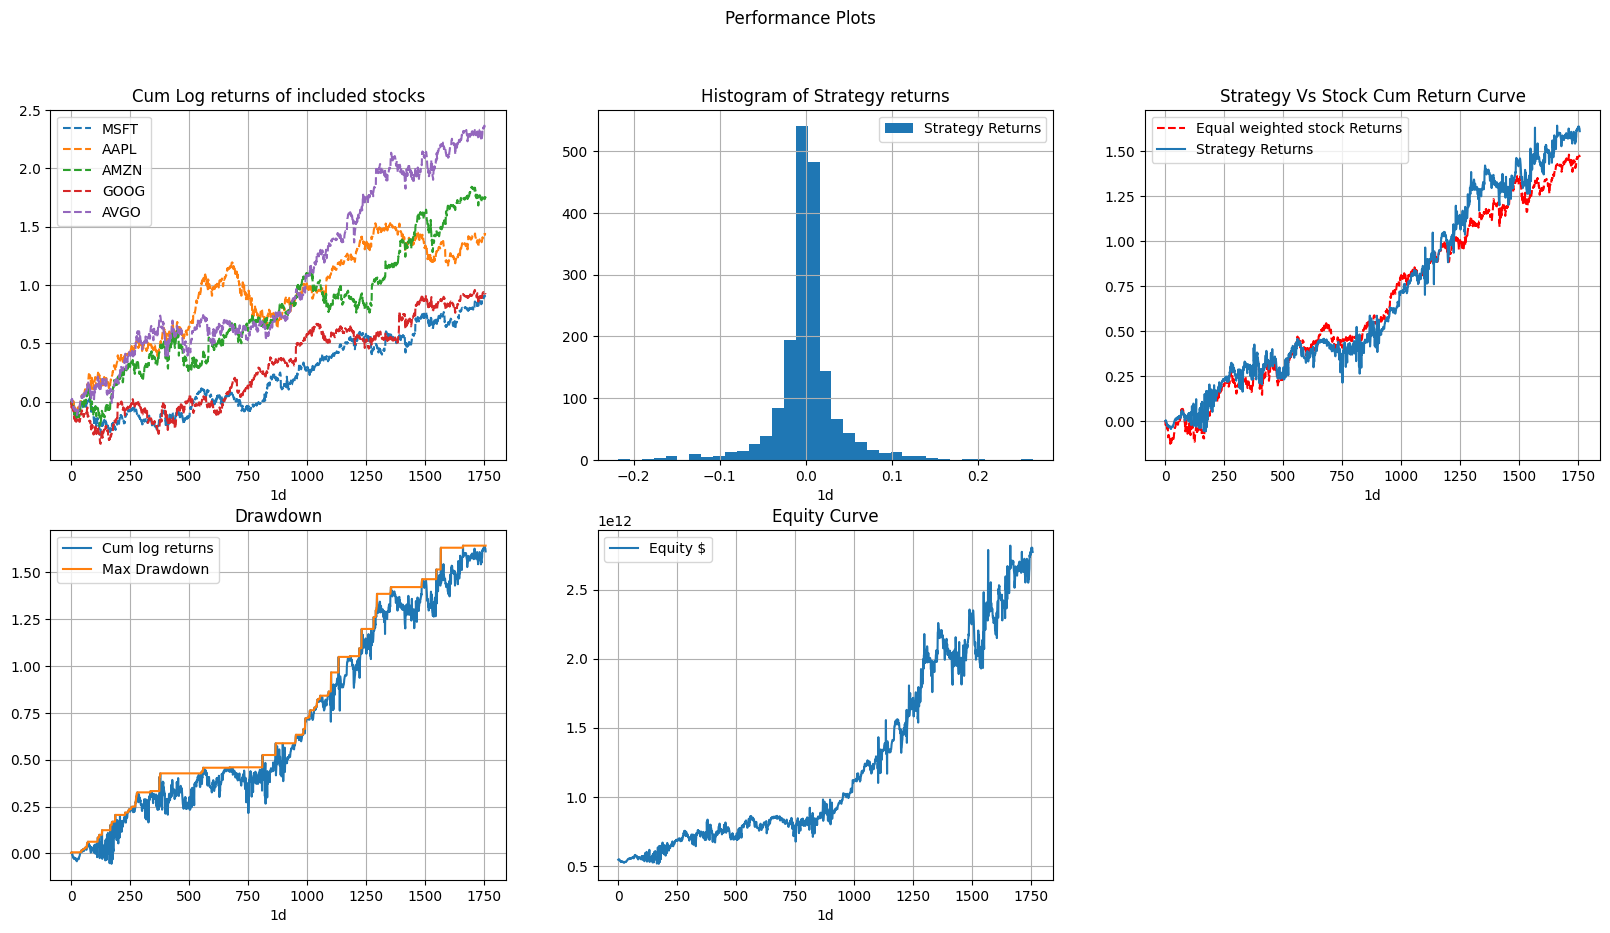

In [10]:
class All_volatile_with_hodl(Common_Class):

  def update_trailing_sl(self, stock, price, atr, sl_multiplier):
    old_stop_loss = self.stop_loss_price['{}'.format(stock)]
    if self.position['{}'.format(stock)] == 1:
      new_stop_loss = price - (atr * sl_multiplier)
      if new_stop_loss > old_stop_loss:
        self.stop_loss_price['{}'.format(stock)] = new_stop_loss
        #print('updating trailing')

    if self.position['{}'.format(stock)] == -1:
      new_stop_loss = price + (atr * sl_multiplier)
      if new_stop_loss < old_stop_loss:
        self.stop_loss_price['{}'.format(stock)] = new_stop_loss
        #print('updating trailing')

  def update_tp_sl(self, stock, price, atr, sl_multipler, tp_multiplier):
    if self.position['{}'.format(stock)] == 1:
      self.take_profit_price['{}'.format(stock)] = price + (tp_multiplier * atr)
      self.stop_loss_price['{}'.format(stock)] = price - (sl_multipler * atr)

    if self.position['{}'.format(stock)] == -1:
      self.take_profit_price['{}'.format(stock)] = price - (tp_multiplier * atr)
      self.stop_loss_price['{}'.format(stock)] = price + (sl_multipler * atr)

  def go_long(self, bar, stock, quantity = None, dollar = None): # either previously in position or fresh position
    if self.position['{}'.format(stock)] == -1:
      self.position['{}'.format(stock)] = 0
      self.buy_order(bar,stock, quantity = -self.quantity['{}'.format(stock)]) #to clear previous short position and therefore negative quantity.(already in position, thats why negative)
    if quantity:
      self.buy_order (bar, stock, quantity = quantity) # to create new fresh order
    elif dollar:
      if dollar == 'all':
        dollar = self.capital
      else:
        dollar = self.capital/len(self.symbol)
      self.buy_order(bar, stock, dollar = dollar)


  def go_short(self, bar, stock, quantity = None, dollar = None):
    if self.position['{}'.format(stock)] == 1:
      self.position['{}'.format(stock)] = 0
      self.sell_order(bar,stock, quantity = self.quantity['{}'.format(stock)]) #to clear previous long vposition
    if quantity:
      self.sell_order (bar, stock, quantity = quantity) # to create new fresh order
    elif dollar:
      if dollar == 'all':
        dollar = self.capital
      else:
        dollar = self.capital/len(self.symbol)
      self.sell_order(bar, stock, dollar = dollar)

  def stop_loss(self):
    pass

  def take_profit(self):
    pass

  def conditionGenerator(self, ema, bb_low, bb_high, close_price, bar):
    ## Long -- Close price < Lower band & Close price > Exponential Moving Average
    if close_price.iloc[bar] < bb_low.iloc[bar] and close_price.iloc[bar] > ema.iloc[bar]:
        return 1  
    ## Short -- Close price > Lower band & Close price < Exponential Moving Averag
    elif close_price.iloc[bar] > bb_high.iloc[bar] and close_price.iloc[bar] < ema.iloc[bar]:
        return -1
    else:
        return 1

  def run_strategy(self, ema, bb_window, bb_dev, atr_window, sl_multiplier, tp_multiplier): # add the parameters according to the strategy
    self.hodl_capital = 0.2 * self.initial_capital
    self.trading_capital = self.initial_capital - self.hodl_capital
    self.stop = False
    self.trades = 0

    self.take_profit_price = {}
    self.stop_loss_price = {}

    # parameterize ATR window for gridsearch(ALVERN!!! I just set to 14 first)
    atr_window = 14
    sl_multiplier = 3
    tp_multiplier = 3

    #Preparing data with LTMA and STMA so that can check crossovers. Also initialising with 0 quantity and 0 position

    for stock in self.symbol:
      self.quantity['{}'.format(stock)] = 0
      self.position['{}'.format(stock)] = 0
      self.take_profit_price['{}'.format(stock)] = 0
      self.stop_loss_price['{}'.format(stock)] = 0
      
      # calculate EMA for each stock
      self.all_data[stock]['EMA'] = self.all_data[stock]['Close_Price'].ewm(span=ema, adjust=False).mean()

      # Calculate bollinger bands for each stock
      bollingerbands = BollingerBands(self.all_data[stock]['Close_Price'], window=bb_window, window_dev=bb_dev)
      high = bollingerbands.bollinger_hband()
      low = bollingerbands.bollinger_lband()
      mid = bollingerbands.bollinger_mavg()

      self.all_data[stock]['bb_high'] = high
      self.all_data[stock]['bb_low'] = low
      self.all_data[stock]['bb_mid'] = mid

      indicator_atr = AverageTrueRange(high = self.all_data['{}'.format(stock)]["High_Price"], low = self.all_data['{}'.format(stock)]["Low_Price"], close = self.all_data['{}'.format(stock)]["Close_Price"], window = atr_window, fillna = False)
      atr = indicator_atr.average_true_range()
      self.all_data['{}'.format(stock)]['ATR'] = atr

    # buy hodl stocks at beginning
    # for stock in self.symbol:
    #   date, price = self.return_date_price(0, stock)
    #   if stock in self.hodl_stocks:
    #     self.go_long(0, stock, dollar=self.hodl_capital/len(self.hodl_stocks))
    #   else:
    #     store_quantity = abs(self.quantity['{}'.format(stock)]) # so that I want just the positive numbers in my performance table. I will calculate +/- based on position sign
    #     tb = self.total_balance(0)
    #     self.store_results(0, date, self.position['{}'.format(stock)], price, stock, store_quantity, tb)  
    
    for bar in range(0, len(self.all_data['{}'.format(self.symbol[0])])): # from the available data bar to the last data bar
      #Making a func so that no trade if balance goes below 0
      tb = self.total_balance(bar)
      if tb < 0:
        print("negative capital")
        self.last_trade(bar)
        self.stop = True
        break
      if bar == 0:
        for stock in self.symbol:
          date, price = self.return_date_price(bar, stock)
          if stock in self.hodl_stocks:
            self.go_long(0, stock, dollar=self.hodl_capital/len(self.hodl_stocks))
          else:
            store_quantity = abs(self.quantity['{}'.format(stock)]) # so that I want just the positive numbers in my performance table. I will calculate +/- based on position sign
            tb = self.total_balance(0)
            self.store_results(0, date, self.position['{}'.format(stock)], price, stock, store_quantity, tb)  

      for stock in self.symbol:
        date, price = self.return_date_price(bar, stock)
        if bar == 0: # on first day, buy hodl stocks
          if stock in self.hodl_stocks:
            self.go_long(0, stock, dollar=self.hodl_capital/len(self.hodl_stocks))
          else:
            store_quantity = abs(self.quantity['{}'.format(stock)]) # so that I want just the positive numbers in my performance table. I will calculate +/- based on position sign
            tb = self.total_balance(0)
            self.store_results(0, date, self.position['{}'.format(stock)], price, stock, store_quantity, tb)  
            
        elif bar >= ema and stock in trading_stocks: # when have ema data, start trading
          tp = self.take_profit_price['{}'.format(stock)]
          sl = self.stop_loss_price['{}'.format(stock)]
          curr_atr = self.all_data['{}'.format(stock)]['ATR'].iloc[bar]
          date, price = self.return_date_price(bar, stock)

          if self.position['{}'.format(stock)] == 1:
            if price >= tp or price <= sl: # check if price > take profit or < stop loss
              self.sell_order(bar,stock, quantity = self.quantity['{}'.format(stock)]) # clear order
              self.position['{}'.format(stock)] = 0 # reduce position to 0

          if self.position['{}'.format(stock)] == -1:
            if price <= tp or price >= sl: # check if price < take profit or > stop loss
              self.buy_order(bar,stock, quantity = -self.quantity['{}'.format(stock)]) # clear order
              self.position['{}'.format(stock)] = 0 # reduce position to 0

          if self.position['{}'.format(stock)] in [1, -1]: # if still long or still short
            self.update_trailing_sl(stock, price, curr_atr, sl_multiplier) # update trailing stop loss (if there is a need)


          if self.position['{}'.format(stock)] in [0,-1]: # checking no position or short position
            if self.conditionGenerator(self.all_data[stock]['EMA'], self.all_data[stock]['bb_low'], self.all_data[stock]['bb_high'], self.all_data[stock]['Close_Price'], bar) == 1:
              self.go_long(bar,stock, dollar = self.trading_capital/len(self.symbol)) # go with equal money # Make sure to enter less than initila capital
              self.update_tp_sl(stock, price, curr_atr, sl_multiplier, tp_multiplier) # update tpAndsl (will have to reset anyways)
              #print(f'{self.stop_loss_price[stock]}' + "--------" + f'{self.take_profit_price[stock]}')
              continue # as I am storing data for SR calculations. Dont wnat duplication


          if self.position['{}'.format(stock)] in [0,1]: # checking no position or long position
            if self.conditionGenerator(self.all_data[stock]['EMA'], self.all_data[stock]['bb_low'], self.all_data[stock]['bb_high'], self.all_data[stock]['Close_Price'], bar) == -1:
              self.go_short(bar,stock, dollar =self.trading_capital/len(self.symbol))
              self.update_tp_sl(stock, price, curr_atr, sl_multiplier, tp_multiplier) # update tpAndsl (will have to reset anyways)
              #print(f'{self.stop_loss_price[stock]}' + "--------" + f'{self.take_profit_price[stock]}')
              continue
          
# w/o sl and tp        
#          if self.position['{}'.format(stock)] in [0,-1]: # checking no position or short position
#            if self.conditionGenerator(self.all_data[stock]['EMA'], self.all_data[stock]['bb_low'], self.all_data[stock]['bb_high'], self.all_data[stock]['Close_Price'], bar) == 1:
#              self.go_long(bar,stock, dollar = self.trading_capital/len(self.symbol)) # go with equal money # Make sure to enter less than initila capital
#              #print("--------")
#              continue # as I am storing data for SR calculations. Dont wnat duplication

#          if self.position['{}'.format(stock)] in [0,1]: # checking no position or long position
#            if self.conditionGenerator(self.all_data[stock]['EMA'], self.all_data[stock]['bb_low'], self.all_data[stock]['bb_high'], self.all_data[stock]['Close_Price'], bar) == -1:
#              self.go_short(bar,stock, dollar =self.trading_capital/len(self.symbol)) # go with equal money
#              #print("--------")
#              continue


        #-----Storing all the values for calculating Sharpe-----
        store_quantity = abs(self.quantity['{}'.format(stock)]) # so that I want just the positive numbers in my performance table. I will calculate +/- based on position sign
        tb = self.total_balance(bar)
        self.store_results(0, date, self.position['{}'.format(stock)], price, stock, store_quantity, tb)  # I have used continue in previous "if conditions", So if they didnt execute meaning no trade conditions that day ; trade = 0

    #print("=" *50)
    #print("End of last bar") Now the bar ends, bar is at the last bar value.
    #print("=" *50)
    if self.stop == False: # to make sure not to run this func 2 times when early exit due to negative balance
      self.last_trade(bar)  # amke sure the crossover happens, give more time
    #print(self.stored_data.to_string())
    #print(self.stored_data)
    #return self.stored_data, self.all_data

#stocks = ['MSFT', 'AAPL', 'TSLA']
#stocks = ["BRITANNIA.NS", "ULTRACEMCO.NS","KOTAKBANK.NS", "HEROMOTOCO.NS"]
#stocks = ["C52.SI", "S68.SI", "G13.SI", "V03.SI"]
#stocks = ['AAPL']

  def objective_function(self, ema_window, bb_window, bb_dev, atr_window, sl_multiplier, tp_multiplier):
      # Run the strategy with the provided parameters
      self.run_strategy(ema_window, bb_window, bb_dev, atr_window, sl_multiplier, tp_multiplier)
      
      # Calculate the performance of the strategy
      self.performance()
      
      # Extract the final return from the performance metrics
      final_return = self.capital - self.initial_capital
      
      return final_return
  

  # def grid_search(self, param_grid):
  #     best_score = -np.inf
  #     best_params = {}

  #     for params in product(
  #         param_grid['ema_window'], param_grid['bb_window'], param_grid['bb_dev'],
  #         param_grid['atr_window'], param_grid['sl_multiplier'], param_grid['tp_multiplier']
  #     ):
  #         ema_window, bb_window, bb_dev, atr_window, sl_multiplier, tp_multiplier = params
          
  #         # Run the objective function to evaluate the current parameter combination
  #         score = self.objective_function(ema_window, bb_window, bb_dev, atr_window, sl_multiplier, tp_multiplier)

  #         # Check if this combination gives a better score
  #         if score > best_score:
  #             best_score = score
  #             best_params = {
  #                 'ema_window': ema_window, 
  #                 'bb_window': bb_window, 
  #                 'bb_dev': bb_dev,
  #                 'atr_window': atr_window,
  #                 'sl_multiplier': sl_multiplier,
  #                 'tp_multiplier': tp_multiplier
  #             }

  #     # Print the best parameters and score found
  #     print(f"Best Parameters: {best_params}")
  #     print(f"Best Total Return: {best_score}")

  #     return best_params

  def randomized_cv_search(self, param_grid, n_iter=10):

        best_score = -np.inf
        best_params = {}

        # Generate all possible parameter combinations
        param_combinations = list(product(
            param_grid['ema_window'], param_grid['bb_window'], param_grid['bb_dev'],
            param_grid['atr_window'], param_grid['sl_multiplier'], param_grid['tp_multiplier']
        ))

        # Randomly select a subset of parameter combinations
        random.seed(42)  # For reproducibility
        sampled_combinations = random.sample(param_combinations, min(n_iter, len(param_combinations)))

        for params in sampled_combinations:
            ema_window, bb_window, bb_dev, atr_window, sl_multiplier, tp_multiplier = params

            # Run the objective function to evaluate the current parameter combination
            score = self.objective_function(ema_window, bb_window, bb_dev, atr_window, sl_multiplier, tp_multiplier)

            # Check if this combination gives a better score
            if score > best_score:
                best_score = score
                best_params = {
                    'ema_window': ema_window,
                    'bb_window': bb_window,
                    'bb_dev': bb_dev,
                    'atr_window': atr_window,
                    'sl_multiplier': sl_multiplier,
                    'tp_multiplier': tp_multiplier
                }

        # Print the best parameter set and score found
        print(f"Best Parameters from Randomized CV: {best_params}")
        print(f"Best Total Return from Randomized CV: {best_score}")

        return best_params

if __name__ == "__main__":
    initial_capital = 500000
    training_start = "2010-01-01"
    training_end = "2016-12-31"
    testing_start = "2017-01-01"
    testing_end = "2019-12-31"
    trading_stocks = ['MSFT', 'AAPL', 'AMZN', 'GOOG']
    hodl_stocks = ['AVGO']
    
    # Create an instance of the strategy class
    A = All_volatile_with_hodl(trading_stocks, hodl_stocks, training_start, training_end, "1d", initial_capital, 0.00, False)
    
    # Define the parameter grid for grid search
    param_grid = {
      'ema_window': [100, 150, 200],
      'bb_window': [15, 20, 25], 
      'bb_dev': [1, 1.5, 2, 3],
      'atr_window': [10, 14, 20],
      'sl_multiplier': [1, 2, 3], 
      'tp_multiplier': [1, 2, 3]   
    }
    
    # # Perform grid search
    # best_params = A.grid_search(param_grid)

    # Perform randomized CV search to find the optimal parameter set
    best_params = A.randomized_cv_search(param_grid, n_iter=20)
    
    # Run the strategy with the best parameters found
    A.run_strategy(
        best_params['ema_window'], 
        best_params['bb_window'], 
        best_params['bb_dev'], 
        best_params['atr_window'], 
        best_params['sl_multiplier'], 
        best_params['tp_multiplier']
    )
    
    # Evaluate performance with the best parameters
    A.performance()
    A.performance_plots()

  #UnboundLocalError: local variable 'bar' referenced before assignment
  # If duration of test or difference between start date aand end date is less than MA
